## Libraries

In [2]:
import numpy as np
import pandas as pd
import scipy.integrate as integrate
import scipy.interpolate as interpolate
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# XRD
## Import the data
In this case I had a folder called 'XRD' in the same directory as this file which contained the .csv with the data.
The following cell can be changed as needed, the important thing it to put the path of the files correctly.

In [3]:
this_file_path = os.path.abspath('') #Path for this file
this_file_path
XRD_ITO_path = os.path.join(this_file_path, 'XRD', 'ITO_gi20_80.csv')
XRD_ITO_WO3_path = os.path.join(this_file_path, 'XRD', 'ITO+WO3_gi20_80.csv')


df_XRD_ITO = pd.read_csv(XRD_ITO_path)

df_XRD_ITO_WO3 = pd.read_csv(XRD_ITO_WO3_path)

df_XRD_ITO.head()

,Angle,TimePerStep,Intensity,ESD
0,20.04,20,13,3.6056
1,20.12,20,11,3.3166
2,20.20,20,14,3.7417
3,20.28,20,12,3.4641
4,20.36,20,10,3.1623


### Plot the ITO XRD

/tmp/ipykernel_27683/3496258047.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(yticks)


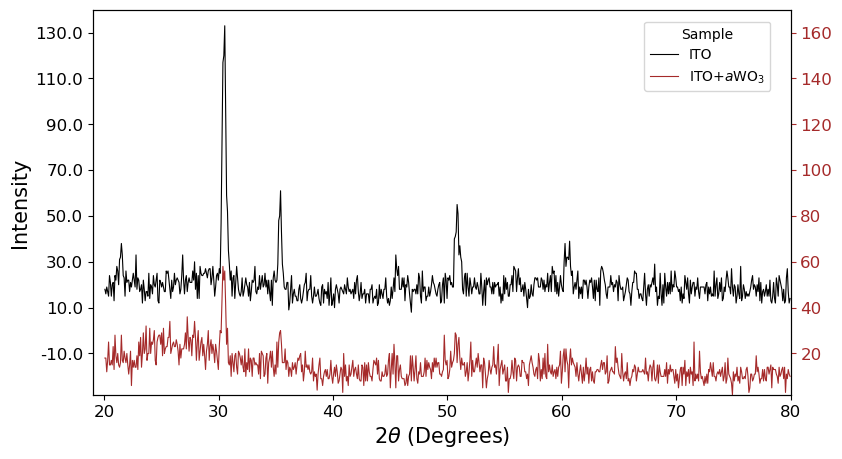

In [4]:
x = df_XRD_ITO['Angle']
y = df_XRD_ITO[' Intensity']+35 #I want the y value to be increased by 35 so that I can show both diffractograms in the same plot for comparison.
x_2 = df_XRD_ITO_WO3['Angle'] # This is the same as the last...
y_2 = df_XRD_ITO_WO3[' Intensity']


fig, ax1 = plt.subplots(figsize=(9, 5))

# Plot the first diffractogram
color = 'k'
ax1.plot(x, y, color='k', lw=0.8, label=r'ITO')
ax1.set_xlabel(r'$2\theta$ (Degrees)', size=15)
ax1.set_ylabel('Intensity', color=color, size=15)
ax1.tick_params(axis='y', labelcolor=color, color = color, labelsize = 12)
ax1.tick_params(axis='x', labelcolor=color, color = color, labelsize = 12)
ax1.set_xlim(19, 80)
ax1.set_ylim(2, 170)

# Create a second y-axis and plot the second dataset
ax2 = ax1.twinx()
color = 'brown'
ax2.plot(x_2, y_2, color=color, lw=0.8, label=r'ITO+$a$WO$_3$')
ax2.tick_params(axis='y', labelcolor=color, color = color, labelsize = 12)
ax2.set_ylim(2, 170)


# Add translation of 30 to the right y-axis tick labels
dist = 30
yticks = ax2.get_yticks() - dist
ax1.set_yticklabels(yticks)


fig.legend(title='Sample', loc='upper left', bbox_to_anchor=(0.73, 0.87))

plt.show()

# Electrochemical Measurements
## Cyclic Voltammetry
### Import the data and cleaning

We are also including: 

$$Q(t) = \int_0^tI(t')dt'$$

and 

$$x(t) = \frac{Q(t)}{ZeN_w Ad}$$

Where $Z = 1$ for hidrogen, $N_w = 1.4 \cdot 10^{28} m^{-3}$ for a density of 5.42 $g/cm^3$

In [5]:
path_cv_data = os.path.join(this_file_path, '20240206','WO3_ITO_20240206_A', 'EC_measurement_batch_2', 'data', 'CV_data.csv')

df_cv = pd.read_csv(path_cv_data)



new_names = {'Time (s)': 'Time [s]',
             'WE(1).Potential (V)': 'Potential [V]',
             'WE(1).Current (A)': 'Current [A]',
             'External(1).External 1 (V)':'850 nm channel',
             'External(1).External 2 (V)':'550 nm channel'}

df_cv.rename(new_names, axis =1, inplace= True)



df_cv['Corrected Time [s]'] = df_cv['Time [s]']-min(df_cv['Time [s]'])

df_cv.drop(columns=['Time [s]'], inplace = True)


df_cv['Charge [C]'] = integrate.cumtrapz(df_cv['Current [A]'], df_cv['Corrected Time [s]'], initial = 0)

df_cv['x'] = np.abs(df_cv['Charge [C]']/(1.602*305*1.3*10**(-4)*1.407))



df_cv.head()

,Potential applied (V),Current [A],Potential [V],Scan,Index,Q+,Q-,550 nm channel,850 nm channel,Corrected Time [s],Charge [C],x
0,0.369110,-1.715088e-07,0.365143,1,1,0.007902,-0.011217,3.623657,4.153137,0.00000,0.000000e+00,0.000000e+00
1,0.371552,1.013184e-07,0.365417,1,2,0.007902,-0.011217,3.644714,4.153137,0.12207,-4.284073e-09,4.793548e-08
2,0.373993,2.337646e-07,0.370575,1,3,0.007902,-0.011217,3.623962,4.133301,0.24414,1.616772e-08,1.809043e-07
3,0.376434,-1.004028e-07,0.370087,1,4,0.007902,-0.011217,3.604431,4.153442,0.36621,2.430746e-08,2.719817e-07
4,0.373993,2.471924e-08,0.371582,1,5,0.007902,-0.011217,3.624573,4.153137,0.48828,1.968811e-08,2.202948e-07


## Signals vs time

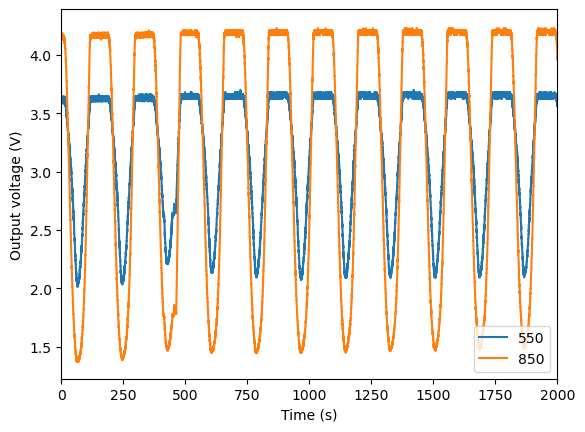

In [6]:

plt.plot(df_cv['Corrected Time [s]'], df_cv['550 nm channel'], label = 550)
plt.plot(df_cv['Corrected Time [s]'], df_cv['850 nm channel'], label = 850)
plt.legend(loc = 'lower right')
plt.xlabel('Time (s)')
plt.ylabel('Output voltage (V)')
plt.xlim(0,2000)
plt.show()

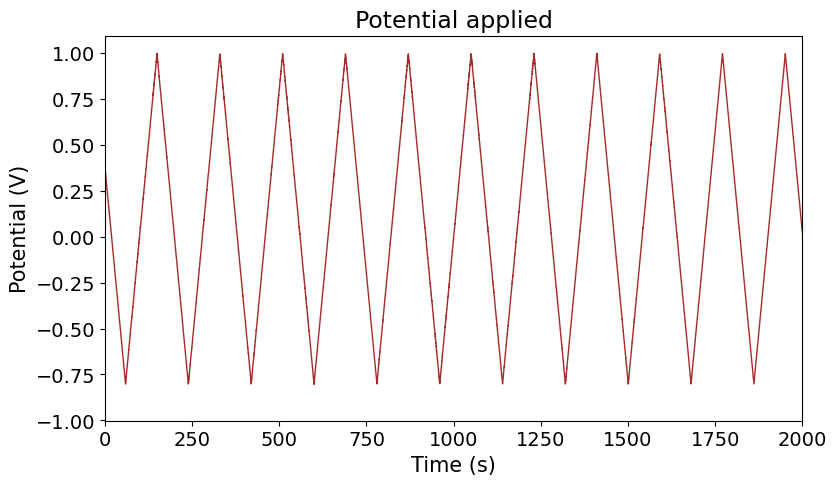

In [7]:
x = df_cv['Corrected Time [s]']
y = df_cv['Potential [V]']

plt.figure(figsize=(9,5))
plt.plot((x), y, color = 'brown', lw = 1)
plt.xlim(0,2000)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlabel(r'Time (s)', size = 15)
plt.ylabel(r'Potential (V)', size = 15)
plt.title('Potential applied', size = 17)
plt.show()

## Cyclic Voltammetry

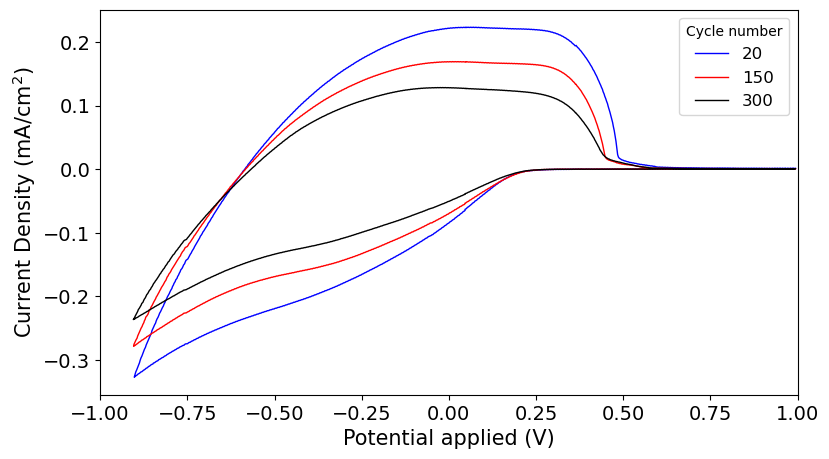

In [8]:
x_20 = df_cv[df_cv['Scan'] == 20]['Potential [V]']
y_20 = df_cv[df_cv['Scan'] == 20]['Current [A]']/1.1*1000

x_150 = df_cv[df_cv['Scan'] == 150]['Potential [V]']
y_150 = df_cv[df_cv['Scan'] == 150]['Current [A]']/1.1*1000

x_300 = df_cv[df_cv['Scan'] == 300]['Potential [V]']
y_300 = df_cv[df_cv['Scan'] == 300]['Current [A]']/1.1*1000

plt.figure(figsize=(9,5))
plt.plot(x_20, y_20, color = 'blue', lw = 1, label = 20)
plt.plot(x_150, y_150, color = 'red', lw = 1, label = 150)
plt.plot(x_300, y_300, color = 'k', lw = 1, label = 300)
plt.xlim(-1,1)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlabel(r'Potential applied (V)', size = 15)
plt.ylabel(r'Current Density (mA/cm$^2$)', size = 15)
plt.legend(title = 'Cycle number', fontsize = 12)
plt.show()

## Charge vs Cycle

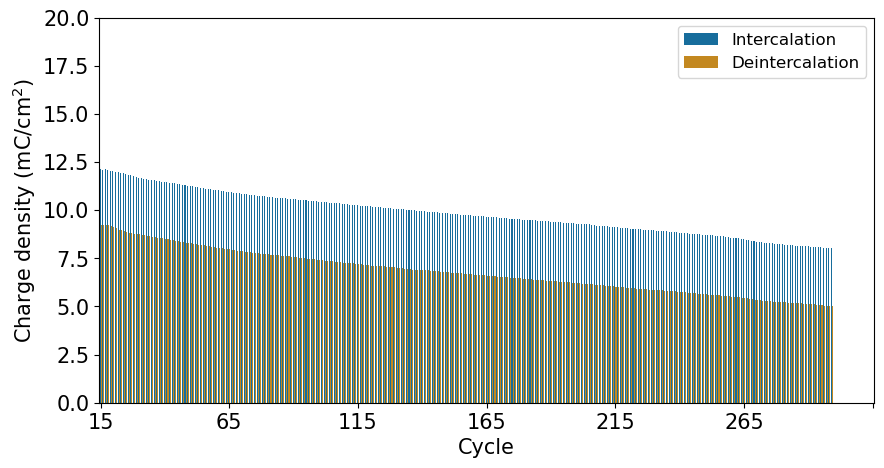

In [9]:
df_cv_charge = df_cv[(df_cv['Scan'] > 14) & (df_cv['Scan'] < 300)][['Scan', 'Q+', 'Q-']].groupby('Scan').mean().reset_index()
df_cv_charge['Q-'] = np.abs(df_cv_charge['Q-'])

df_cv_charge.rename(mapper = {'Q+': 'Deintercalation',
                              'Q-': 'Intercalation'}, axis = 1, inplace=True)

df_charge = pd.melt(df_cv_charge, id_vars=['Scan'], value_vars=['Intercalation','Deintercalation'])
df_charge['value'] = df_charge['value']/1.1*1000 # mC per unit area

plt.figure(figsize=(10,5))
sns.barplot(data=df_charge,
            x = 'Scan',
            y = 'value',
            hue = 'variable',
            palette= 'colorblind',
            dodge = True)
plt.xticks(np.linspace(0,300, 7), size = 15)
plt.yticks(size = 15)
plt.xlabel('Cycle', size = 15)
plt.ylabel(r'Charge density (mC/cm$^2$)', size = 15)
plt.legend(loc = 'upper right', fontsize = 12)
plt.xlim(-0.5,300.5)
plt.ylim(0,20)
plt.show()

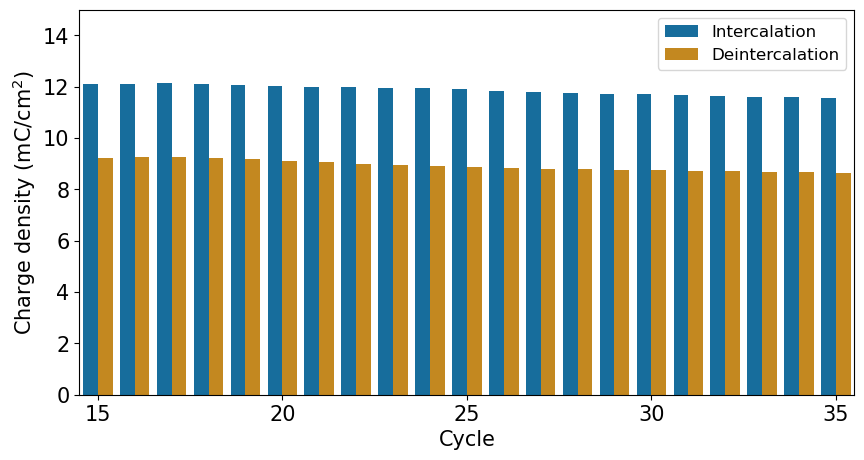

In [10]:
df_cv_charge = df_cv[(df_cv['Scan'] > 14) & (df_cv['Scan'] < 66)][['Scan', 'Q+', 'Q-']].groupby('Scan').mean().reset_index()
df_cv_charge['Q-'] = np.abs(df_cv_charge['Q-'])

df_cv_charge.rename(mapper = {'Q+': 'Deintercalation',
                              'Q-': 'Intercalation'}, axis = 1, inplace=True)

df_charge = pd.melt(df_cv_charge, id_vars=['Scan'], value_vars=['Intercalation','Deintercalation'])
df_charge['value'] = df_charge['value']/1.1*1000 # mC per unit area

plt.figure(figsize=(10,5))
sns.barplot(data=df_charge,
            x = 'Scan',
            y = 'value',
            hue = 'variable',
            palette= 'colorblind',
            dodge = True)
plt.xticks(ticks=range(0,80,5), size = 15)
plt.yticks(size = 15)
plt.xlabel('Cycle', size = 15)
plt.ylabel(r'Charge density (mC/cm$^2$)', size = 15)
plt.legend(loc = 'upper right', fontsize = 12)
plt.xlim(-0.5,20.5)
plt.ylim(0,15)
plt.show()



## Optical Data
### Import the data and cleaning
Since the format of the files is wierd (not separated by commas, tabs, just by a variable number of spaces), I am going to transform it into a csv format.
Also, the metadata of the first lines was removed mannually. If you don't remove it you may have problems processing the data.

In [11]:
def to_csv_format(file_path, output_file):
    with open(file_path, 'r') as file:
        data = file.read()

    # Replace commas with periods
    data = data.replace(',', '.')

    # Replace extra spaces with a comma followed by a space
    data = re.sub(r'[ \t]+', ',', data)

    # Write the processed data to the output file
    with open(output_file, 'w') as file:
        file.write(data)


In [12]:
# Path of the files

path_ts_data = os.path.join(this_file_path, '20240206','WO3_ITO_20240206_A', 'EC_measurement_batch_2', 'optics_data')

file_name_550nm = os.path.join(path_ts_data, '550_nm.dat')
file_name_850nm = os.path.join(path_ts_data, '850_nm.dat')

output_csv_550 = os.path.join(path_ts_data, '550nm.csv')
output_csv_850 = os.path.join(path_ts_data, '850nm.csv') 

# Clean the files (after the metadata has been removed)

to_csv_format(file_name_550nm, output_csv_550)
to_csv_format(file_name_850nm, output_csv_850)

# Read and clean the resulting files

df_550 = pd.read_csv(output_csv_550)
df_850 = pd.read_csv(output_csv_850)

df_550.drop(['Value', 'Time'], axis=1, inplace = True)
df_850.drop(['Value', 'Time'], axis=1, inplace = True)

df_550.rename({'Function': 'Counts'}, axis = 1, inplace = True)
df_850.rename({'Function': 'Counts'}, axis = 1, inplace = True)

df_550.head()


,Seconds,Counts
0,0.100,23286.3473
1,0.205,23331.0436
2,0.317,23396.4448
3,0.427,23317.7390
4,0.535,23409.4785


In [13]:
df_550.info() #To confirm that everything is fine and there are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86618 entries, 0 to 86617
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Seconds  86618 non-null  float64
 1   Counts   86618 non-null  float64
dtypes: float64(2)
memory usage: 1.3 MB


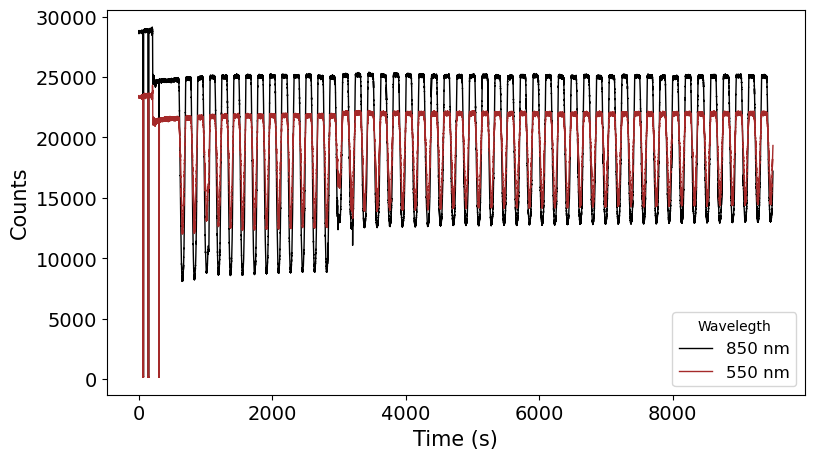

In [14]:
x = df_550['Seconds']
y = df_550['Counts']

x_2 = df_850['Seconds']
y_2 = df_850['Counts']

plt.figure(figsize=(9,5))
plt.plot(x_2, y_2, color = 'k', lw = 1, label = r'850 nm')
plt.plot(x, y, color = 'brown', lw = 1, label = r'550 nm')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlabel(r'Time (s)', size = 15)
plt.ylabel(r'Counts', size = 15)
plt.legend(title = 'Wavelegth', loc='lower right', fontsize = 12)
plt.show()

### From the last plot the normalization factor (reference) for transmittance can be obtained

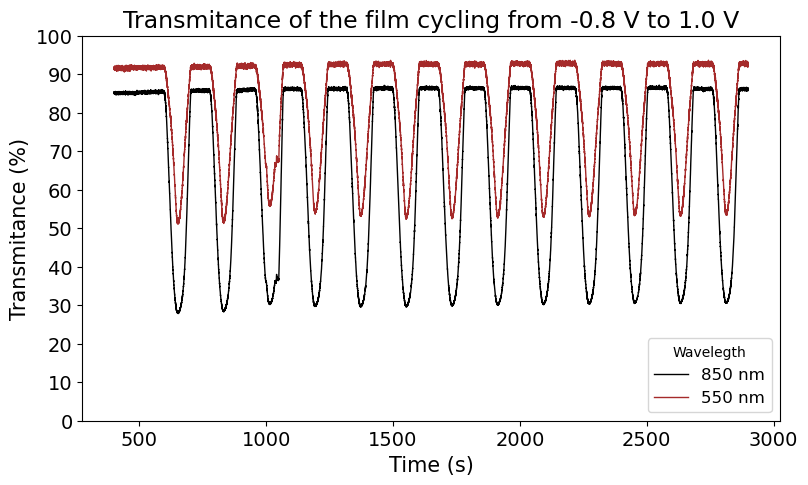

In [15]:
x = df_550[(df_550['Seconds']>400) & (df_550['Seconds']<2900)]['Seconds']
y = df_550[(df_550['Seconds']>400) & (df_550['Seconds']<2900)]['Counts']/23500*100 #Normalization factor

x_2 = df_850[(df_850['Seconds']>400) & (df_850['Seconds']<2900)]['Seconds']
y_2 = df_850[(df_850['Seconds']>400) & (df_850['Seconds']<2900)]['Counts']/29000*100 #Normalization factor

plt.figure(figsize=(9,5))
plt.plot(x_2, y_2, color = 'k', lw = 1, label = r'850 nm')
plt.plot(x, y, color = 'brown', lw = 1, label = r'550 nm')
plt.ylim(0,100)
plt.xticks(size = 14)
plt.yticks(ticks=[i for i in range(0,110, 10)], size = 14)
plt.xlabel(r'Time (s)', size = 15)
plt.ylabel(r'Transmitance (%)', size = 15)
plt.title('Transmitance of the film cycling from -0.8 V to 1.0 V', size = 17)
plt.legend(title = 'Wavelegth', loc='lower right', fontsize = 12)
plt.show()

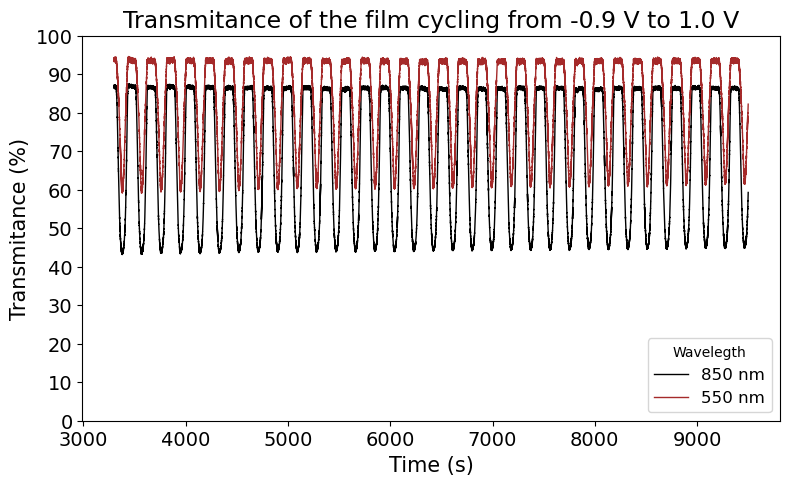

In [16]:
x = df_550[(df_550['Seconds']>3300) & (df_550['Seconds']<12900)]['Seconds']
y = df_550[(df_550['Seconds']>3300) & (df_550['Seconds']<12900)]['Counts']/23500*100  #Normalization factor was determined to be this number ()

x_2 = df_850[(df_850['Seconds']>3300) & (df_850['Seconds']<12900)]['Seconds']
y_2 = df_850[(df_850['Seconds']>3300) & (df_850['Seconds']<12900)]['Counts']/29000*100

plt.figure(figsize=(9,5))
plt.plot(x_2, y_2, color = 'k', lw = 1, label = r'850 nm')
plt.plot(x, y, color = 'brown', lw = 1, label = r'550 nm')
plt.ylim(0,100)
plt.xticks(size = 14)
plt.yticks(ticks=[i for i in range(0,110, 10)], size = 14)
plt.xlabel(r'Time (s)', size = 15)
plt.ylabel(r'Transmitance (%)', size = 15)
plt.title('Transmitance of the film cycling from -0.9 V to 1.0 V', size = 17)
plt.legend(title = 'Wavelegth', fontsize = 12, loc='lower right')
plt.show()

# Chronopotentiometry data
## Electrochemical data
### Import data and cleaning

In [17]:
path_cp_ts_data = os.path.join(this_file_path, '20240207','WO3_ITO_20240206_B', 'CP', 'data', 'CP_3.txt')

df_cp = pd.read_csv(path_cp_ts_data, sep = '\t')

new_names = {'Time (s)': 'Time [s]',
             'WE(1).Potential (V)': 'Potential [V]',
             'WE(1).Current (A)': 'Current [A]',
             'External(1).External 1 (V)':'850 nm channel',
             'External(1).External 2 (V)':'550 nm channel'}

df_cp.rename(new_names, axis =1, inplace= True)



df_cp['Corrected Time [s]'] = df_cp['Time [s]']-min(df_cp['Time [s]'])

df_cp.drop(columns=['Time [s]'], inplace = True)


df_cp['Charge [C]'] = integrate.cumtrapz(df_cp['Current [A]'], df_cp['Corrected Time [s]'], initial = 0)

df_cp['x'] = np.abs(df_cp['Charge [C]']/(1.602*305*1.3*10**(-4)*1.407))



df_cv.head()

,Potential applied (V),Current [A],Potential [V],Scan,Index,Q+,Q-,550 nm channel,850 nm channel,Corrected Time [s],Charge [C],x
0,0.369110,-1.715088e-07,0.365143,1,1,0.007902,-0.011217,3.623657,4.153137,0.00000,0.000000e+00,0.000000e+00
1,0.371552,1.013184e-07,0.365417,1,2,0.007902,-0.011217,3.644714,4.153137,0.12207,-4.284073e-09,4.793548e-08
2,0.373993,2.337646e-07,0.370575,1,3,0.007902,-0.011217,3.623962,4.133301,0.24414,1.616772e-08,1.809043e-07
3,0.376434,-1.004028e-07,0.370087,1,4,0.007902,-0.011217,3.604431,4.153442,0.36621,2.430746e-08,2.719817e-07
4,0.373993,2.471924e-08,0.371582,1,5,0.007902,-0.011217,3.624573,4.153137,0.48828,1.968811e-08,2.202948e-07


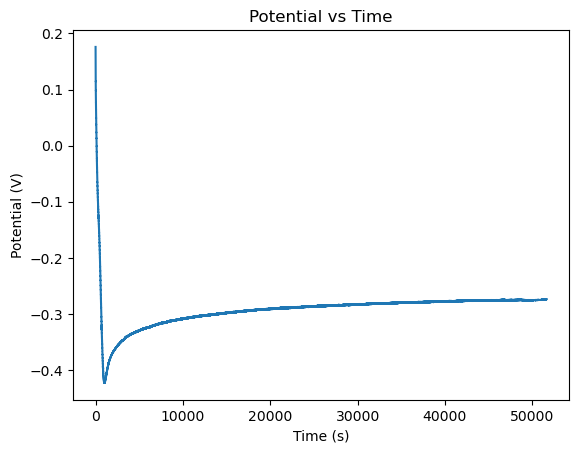

In [18]:
plt.plot(df_cp['Corrected Time [s]'], df_cp['Potential [V]'])
plt.title('Potential vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Potential (V)')
plt.show()

The potential response is not similar to the expected...

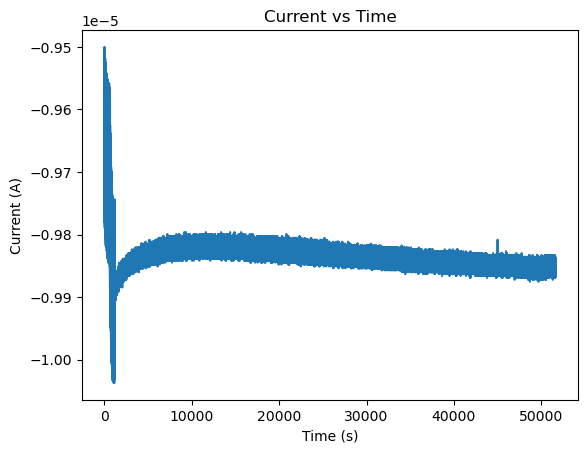

In [19]:
plt.plot(df_cp['Corrected Time [s]'], df_cp['Current [A]'])
plt.title('Current vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.show()

### The current is $10^{-5}$ as expected

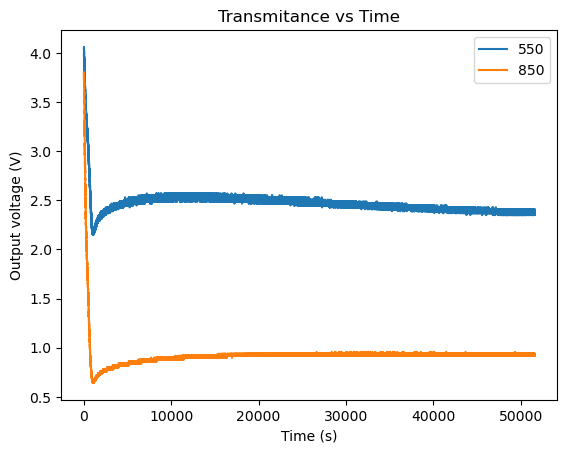

In [20]:


plt.plot(df_cp['Corrected Time [s]'], df_cp['550 nm channel'], label = 550)
plt.plot(df_cp['Corrected Time [s]'], df_cp['850 nm channel'], label = 850)
plt.title('Transmitance vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Output voltage (V)')
plt.legend()
plt.show()

### The signal is a litle bit noisy but can be corrected, which may be difficult to differenciate

# Smoothing signals

## 850 nm

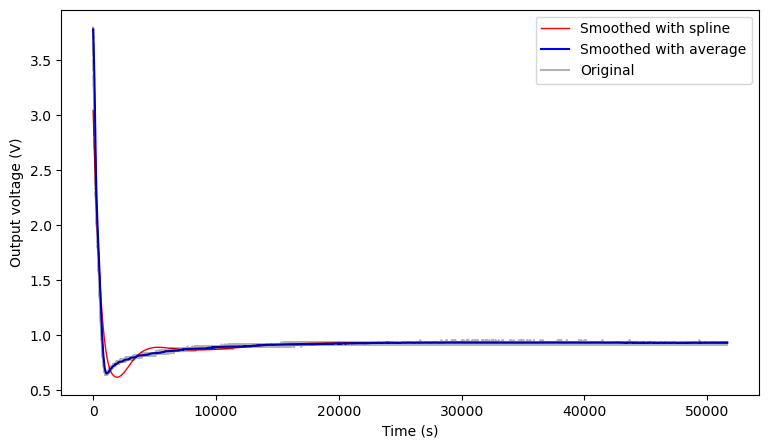

In [21]:
df_cp['Smooth 850'] = df_cp['850 nm channel'].rolling(window=10000, min_periods=1).mean()

spl = interpolate.UnivariateSpline(df_cp['Corrected Time [s]'], df_cp['850 nm channel'])
spl.set_smoothing_factor(10000)

xs = np.linspace(0, max(df_cp['Corrected Time [s]']), 10000)
y = df_cp['Smooth 850']

plt.figure(figsize=(9,5))
plt.plot(xs, spl(xs), color = 'red', lw=1, label = 'Smoothed with spline')
plt.plot(df_cp['Corrected Time [s]'],y, color = 'blue', label = 'Smoothed with average')
plt.plot(df_cp['Corrected Time [s]'],df_cp['850 nm channel'], color = 'k', alpha = 0.3, label = 'Original')
plt.xlabel('Time (s)')
plt.ylabel('Output voltage (V)')
plt.legend()
plt.show()

### It doesn't appear to be much difference between the smoothed signals. Zooming in...

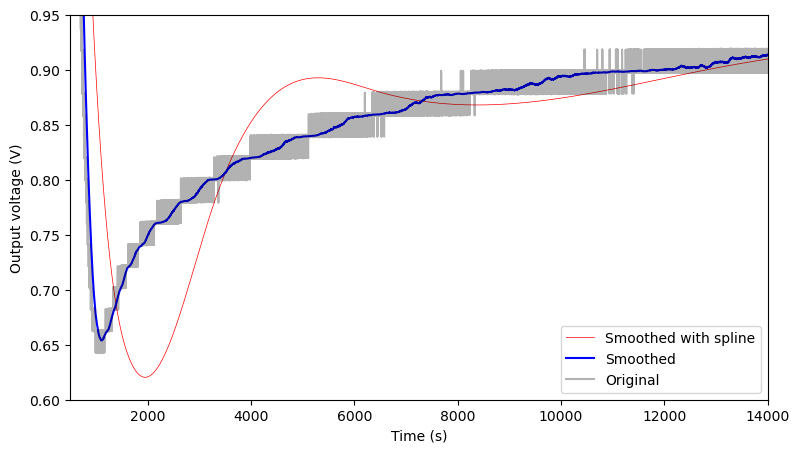

In [22]:
plt.figure(figsize=(9,5))
plt.plot(xs, spl(xs), color = 'red', lw=0.5, label = 'Smoothed with spline')
plt.plot(df_cp['Corrected Time [s]'],y, color = 'blue', label = 'Smoothed')
plt.plot(df_cp['Corrected Time [s]'],df_cp['850 nm channel'], color = 'k', alpha = 0.3, label = 'Original')
plt.xlabel('Time (s)')
plt.ylabel('Output voltage (V)')
plt.xlim(500,14000)
plt.ylim(0.6, 0.95)
plt.legend()
plt.show()

## Smoothing with average is not enough and using average and spline may not be as accurate
It can be seen that the smoothed signal with average is still very noisy, it is probably better to keep the spline for later differeciate. However it is worth noticing that the spline is not as accurate as expected. You can see differences in the position of the minima.

### This is problably due to the high smoothing. Second attempt:

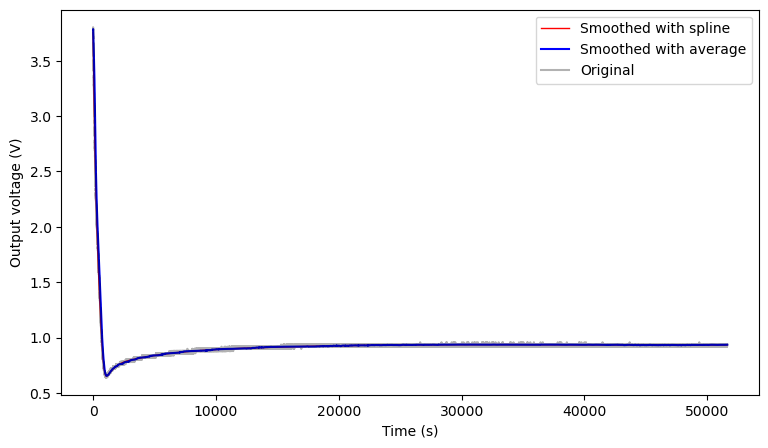

In [23]:
df_cp['Smooth 850'] = df_cp['850 nm channel'].rolling(window=10000, min_periods=1).mean()

spl = interpolate.UnivariateSpline(df_cp['Corrected Time [s]'], df_cp['850 nm channel'])
spl.set_smoothing_factor(400)

xs = np.linspace(0, max(df_cp['Corrected Time [s]']), 10000)
y = df_cp['Smooth 850']

plt.figure(figsize=(9,5))
plt.plot(xs, spl(xs), color = 'red', lw=1, label = 'Smoothed with spline')
plt.plot(df_cp['Corrected Time [s]'],y, color = 'blue', label = 'Smoothed with average')
plt.plot(df_cp['Corrected Time [s]'],df_cp['850 nm channel'], color = 'k', alpha = 0.3, label = 'Original')
plt.xlabel('Time (s)')
plt.ylabel('Output voltage (V)')
plt.legend()
plt.show()

### Zooming  in a little bit more

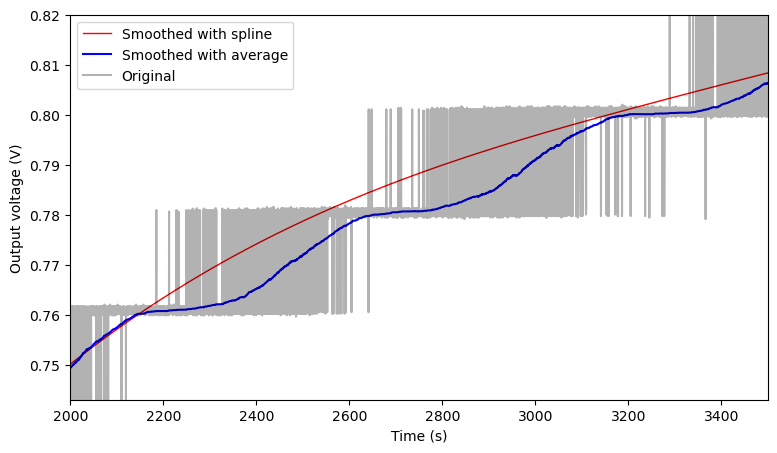

In [24]:
plt.figure(figsize=(9,5))
plt.plot(xs, spl(xs), color = 'red', lw=1, label = 'Smoothed with spline')
plt.plot(df_cp['Corrected Time [s]'],y, color = 'blue', label = 'Smoothed with average')
plt.plot(df_cp['Corrected Time [s]'],df_cp['850 nm channel'], color = 'k', alpha = 0.3, label = 'Original')
plt.xlabel('Time (s)')
plt.ylabel('Output voltage (V)')
plt.xlim(2000,3500)
plt.ylim(0.743, 0.82)
plt.legend()
plt.show()

### The spline with smoothing_factor 400 represents the data properly

In [25]:
t_i = min(df_cp['Corrected Time [s]'])
t_f = max(df_cp['Corrected Time [s]'])


time = np.linspace(t_i, t_f, 400)
smoothed_850 = spl(time)

smoothed_850.shape

(400,)

## Calculating the differential color efficiency

This is can be estimated as:

$$ K(\lambda, x) = -\frac{1}{T(\lambda, x)}\frac{dT(\lambda, x)}{dq}$$

Which is independent of the normalization factor of the transmittance. In this case, it is easier to calculate:

$$ \frac{dT(\lambda, x)}{dq} = \frac{dT(\lambda, x)}{dt}\frac{dt}{dq} = \frac{1}{I}\frac{dT(\lambda, x)}{dt}$$

As a result:

$$ K(\lambda, x) = -\frac{1}{I\cdot T(\lambda, x)}\frac{dT(\lambda, x)}{dt}$$

And

$$ x = \frac{It}{eN_wAd} $$

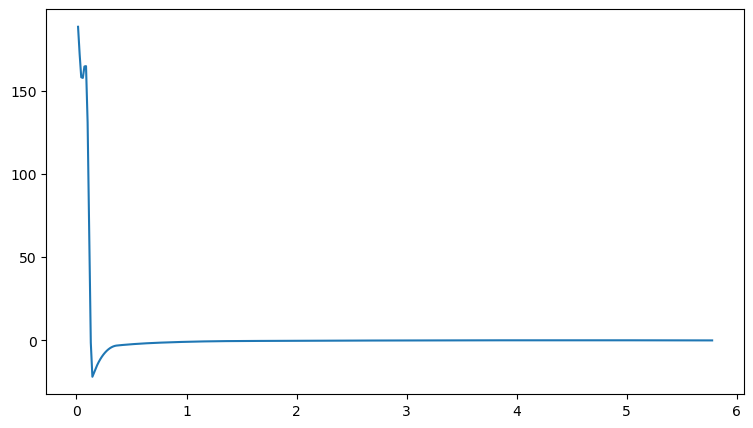

In [26]:
dt_dq = np.diff(smoothed_850)/np.diff(time)

k = -dt_dq/(10**(-5)*smoothed_850[:-1])

x_ratio = 10**(-1)*time[1:]/(1.602*305*1.3*1.407)

plt.figure(figsize=(9,5))
plt.plot(x_ratio, k)


#plt.ylim(0,1000)
plt.show()

### 550 nm

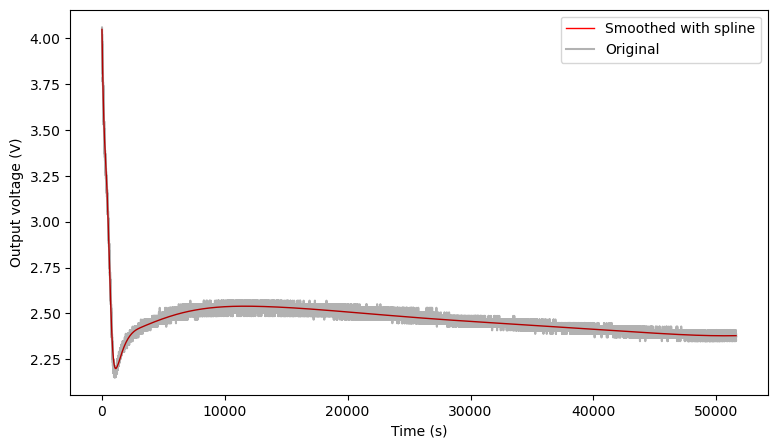

In [44]:
spl_550 = interpolate.UnivariateSpline(df_cp['Corrected Time [s]'], df_cp['550 nm channel'])
spl_550.set_smoothing_factor(950)

xs = np.linspace(0, max(df_cp['Corrected Time [s]']), 1000)


plt.figure(figsize=(9,5))
plt.plot(xs, spl_550(xs), color = 'red', lw=1, label = 'Smoothed with spline')
plt.plot(df_cp['Corrected Time [s]'],df_cp['550 nm channel'], color = 'k', alpha = 0.3, label = 'Original')
plt.xlabel('Time (s)')
plt.ylabel('Output voltage (V)')
plt.legend()
plt.show()

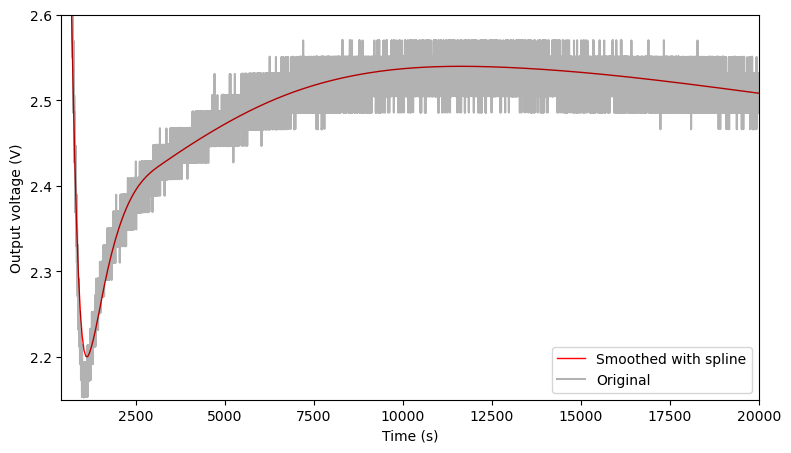

In [45]:
plt.figure(figsize=(9,5))
plt.plot(xs, spl_550(xs), color = 'red', lw=1, label = 'Smoothed with spline')
plt.plot(df_cp['Corrected Time [s]'],df_cp['550 nm channel'], color = 'k', alpha = 0.3, label = 'Original')
plt.xlabel('Time (s)')
plt.ylabel('Output voltage (V)')
plt.xlim(400,20000)
plt.ylim(2.15, 2.6)
plt.legend()
plt.show()

In [46]:
smoothed_550 = spl(time)

smoothed_550.shape

(400,)

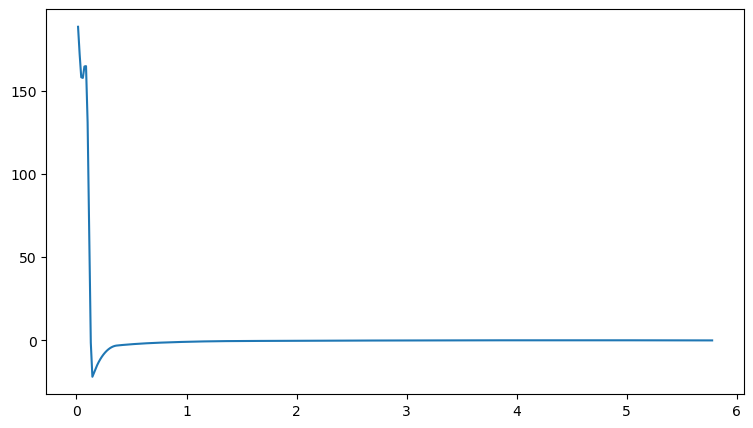

In [47]:
dt_dq = np.diff(smoothed_550)/np.diff(time)

k = -dt_dq/(10**(-5)*smoothed_550[:-1])

x_ratio = 10**(-1)*time[1:]/(1.602*305*1.3*1.407)

plt.figure(figsize=(9,5))
plt.plot(x_ratio, k)


#plt.ylim(0,1000)
plt.show()

## Optical data
### Import data and cleaning

#### Theoretical coloration efficiency

In [48]:
def coloration_efficiency(x, C_56, C_45 = 0, C_46 = 0, x_scale = 1):

    x = x/x_scale
    
    k_eff = C_56*(1/2*(x-2)**2*(1/2-x)) + C_45*(1/2*(x)**2*(3/2-x)) + C_46*(1/4*x*(x-1)*(x-2))
    
    return k_eff

### Limit x to the [0,2] interval

In [94]:

lim_x = x_ratio[0:138]

print(max(lim_x))

x_ratio_2 = x_ratio[:138]

x_ratio_2.shape

1.9976543742528776


(138,)

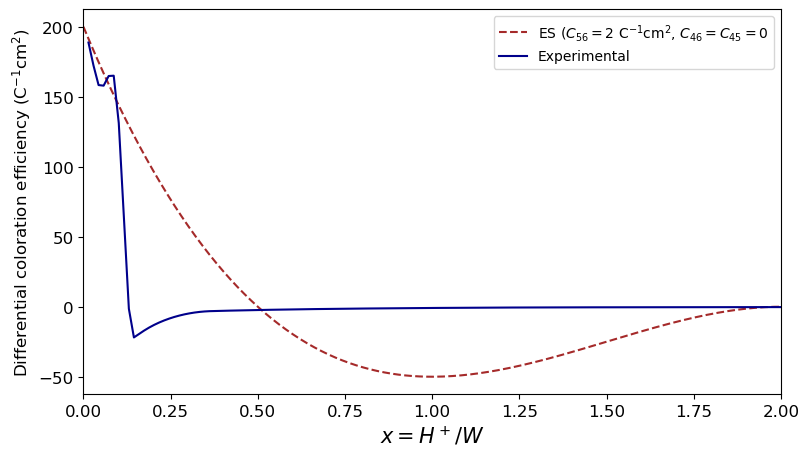

In [98]:
x = np.linspace(0, 2, 300)
k_eff = coloration_efficiency(x, C_56=200,C_45=0, C_46=0)

plt.figure(figsize=(9,5))
plt.plot(x, k_eff, ls = '--', color = 'brown', label = r'ES ($C_{56}=2$ C$^{-1}$cm$^2$, $C_{46}=C_{45}=0$')
plt.plot(x_ratio_2, k[:138], color = 'darkblue', label = 'Experimental')


#plt.plot(x_ratio, k, color = 'k')
plt.xlim(0,2.5)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.ylabel(r'Differential coloration efficiency (C$^{-1}$cm$^2$)', size = 12)
plt.xlabel(r'$x = H^+/W$', size = 15)
plt.xlim(0,2)
plt.legend()
plt.show()

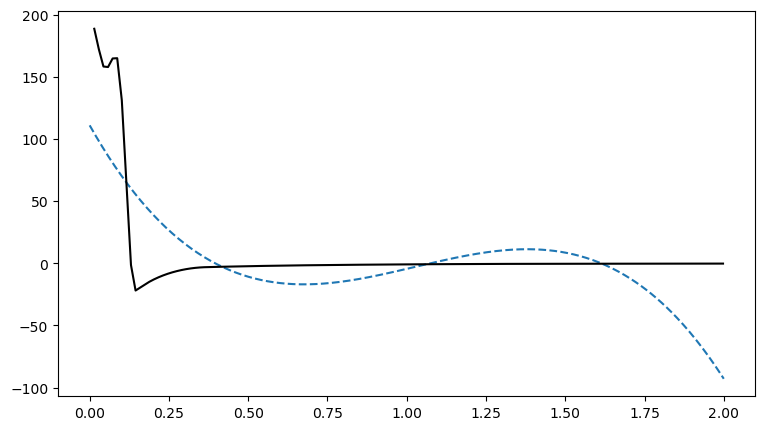

In [101]:
uncert=3*np.ones(shape=x_ratio_2.shape)


popt, pcov = optimize.curve_fit(coloration_efficiency, x_ratio_2, k[:138], sigma=uncert,
                                p0=(200, 0, 0, 1), method="lm")


x = np.linspace(0, 2, 500)
k_eff = coloration_efficiency(x, C_56=popt[0],C_45=popt[1], C_46=popt[2])

plt.figure(figsize=(9,5))
plt.plot(x, k_eff, ls = '--')
plt.plot(x_ratio_2, k[:138], color = 'k')

plt.show()


In [102]:
print(popt)

[ 110.9859854    92.95745728 -239.35173893    1.13406872]


# The results of the experiment cannot be fitted by the theory
This can be due to the uncertainty un the x value, which can not be calculated accurately due to two main factors:

- Low porosity of the film (The intercalating atoms may not be ).
- Unknown density of the film

Additionally it is worth noticing that the behavior of the voltage during this experiment is not well-understood.

# Theory
## Site Saturated theory (SS) plot

In [103]:
def Pss(x):
    return x*(1-x)

Text(0.5, 0, 'x = H$^+$/W')

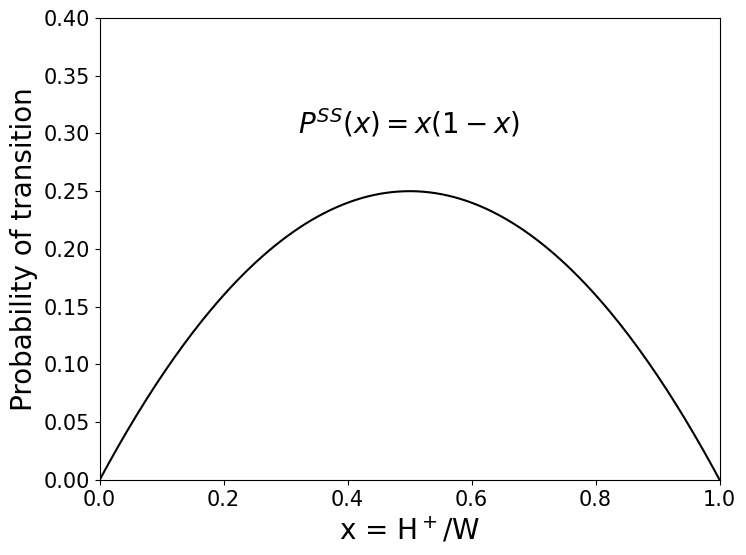

In [104]:
x = np.linspace(0,1,200)

plt.figure(figsize=(8,6))
plt.plot(x, Pss(x), color = 'k')
plt.xlim(0,1)
plt.ylim(0,0.4)
plt.text(x = 0.5, y = 0.3, s = r'$P^{SS}(x) = x(1-x)$', size = 20, ha = 'center')
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylabel('Probability of transition', size = 20)
plt.xlabel(r'x = H$^+$/W', size = 20)


## Extended site saturated theory (ES) plot

In [105]:
def Pes_56(x):
    return x*(1-x/2)**3

def Pes_45(x):
    return ((x**3)/4)*(1-x/2)

def Pes_46(x):
    return ((x**2)/4)*(1-x/2)**2

Text(0.5, 0, 'x = H$^+$/W')

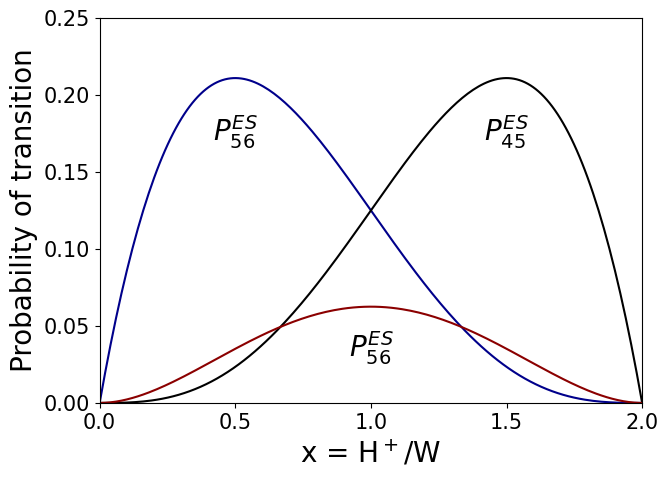

In [ ]:
x = np.linspace(0,2,200)

plt.figure(figsize=(7,5))
plt.plot(x, Pes_56(x), color = 'darkblue', label = r'$P_{56}^{ES}(x)$')
plt.plot(x, Pes_45(x), color = 'k', label = r'$P_{45}^{ES}(x)$')
plt.plot(x, Pes_46(x), color = 'darkred', label = r'$P_{46}^{ES}(x)$')
plt.xlim(0,2)
plt.ylim(0,0.25)
plt.text(x = 0.5, y = 0.17, s = r'$P_{56}^{ES}$', size = 20, ha = 'center')
plt.text(x = 1, y = 0.03, s = r'$P_{56}^{ES}$', size = 20, ha = 'center')
plt.text(x = 1.5, y = 0.17, s = r'$P_{45}^{ES}$', size = 20, ha = 'center')
plt.xticks([0,0.5,1,1.5,2], size = 15)
plt.yticks(size = 15)
plt.ylabel('Probability of transition', size = 20)
plt.xlabel(r'x = H$^+$/W', size = 20)